In [5]:
%load_ext autoreload
%autoreload 2

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.externals import joblib

import numpy as np
import cPickle as pickle
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)


In [7]:
paths = ['../models', '../rainforest', '../scripts']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
        
import dataset
from data import *
from data_generators_leo import get_data, get_data_channels_last

data_path = '..\\data\\'
jpg_path = data_path + 'train-jpg'
batch_size=100

weather_labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
train_csv = get_class_data(train=True, label='weather')
val_csv = get_class_data(train=False, label='weather')

train_labels = np.asarray(train_csv)[:,1:5]
train_data = np.asarray(train_csv)[:,0]
all_zeros_train = [index for index, label in enumerate(train_labels) if sum(label) == 0]
if(all_zeros_train > 0):
    train_data = np.delete(train_data, all_zeros_train)
    train_labels = np.delete(train_labels, all_zeros_train, axis=0)

val_labels = np.asarray(val_csv)[:,1:5]
val_data = np.asarray(val_csv)[:,0]
all_zeros_val = [index for index, label in enumerate(val_labels) if sum(label) == 0]
if(all_zeros_val > 0):
    val_data = np.delete(val_data, all_zeros_val)
    val_labels = np.delete(val_labels, all_zeros_val, axis=0)

print(train_labels.shape)
print(train_data.shape)
print(val_labels.shape)
print(val_data.shape)

(28334L, 4L)
(28334L,)
(12144L, 4L)
(12144L,)


In [8]:
#train_gen = get_data(train_data, '..\\data\\train-jpg', train_labels, 
                                      #flip=True, shift_x=5, shift_y=5, rot_range=10,
                                      #elastic_trans=False, batch_size=8, balance_batches=True)

# train_gen = get_data(train_data, jpg_path, train_labels, batch_size=batch_size, augmentation=True,
#                      hflip=True, vflip=True, shift_x=5, shift_y=5, rot_range=10,
#                      elastic_trans=False, img_size=(128, 128), balance_batches=True)

train_gen = get_data_channels_last(train_data, jpg_path, train_labels, batch_size=batch_size, augmentation=False,
                     img_size=(256,256), balance_batches=True)
        
val_gen = get_data_channels_last(val_data, jpg_path, val_labels, augmentation=False,
                   batch_size=batch_size, img_size=(256,256), balance_batches=True)
 

In [12]:
x=10

mean_clear = np.zeros((x,3))
mean_cloudy = np.zeros((x,3))
mean_haze = np.zeros((x,3))
mean_partly = np.zeros((x,3))

for j in range(x):  
    batch = train_gen.next()
    
    batch_clear = np.zeros((batch_size/4,3))
    batch_cloudy = np.zeros((batch_size/4,3))
    batch_haze = np.zeros((batch_size/4,3))
    batch_partly = np.zeros((batch_size/4,3))
    
    clear = 0
    cloudy = 0
    haze = 0
    partly = 0

    for i in range(batch[0].shape[0]):
        image = batch[0][i,:,:,:]
        
        if(batch[1][i,0] == 1):
            batch_clear[clear,0] = np.mean(image[:,:,0])
            batch_clear[clear,1] = np.mean(image[:,:,1])
            batch_clear[clear,2] = np.mean(image[:,:,2])
            clear = clear+1
        if(batch[1][i,1] == 1):
            batch_cloudy[cloudy,0] = np.mean(image[:,:,0])
            batch_cloudy[cloudy,1] = np.mean(image[:,:,1])
            batch_cloudy[cloudy,2] = np.mean(image[:,:,2])
            cloudy = cloudy+1
        if(batch[1][i,2] == 1):
            batch_haze[haze,0] = np.mean(image[:,:,0])
            batch_haze[haze,1] = np.mean(image[:,:,1])
            batch_haze[haze,2] = np.mean(image[:,:,2])
            haze = haze+1
        if(batch[1][i,3] == 1):
            batch_partly[partly,0] = np.mean(image[:,:,0])
            batch_partly[partly,1] = np.mean(image[:,:,1])
            batch_partly[partly,2] = np.mean(image[:,:,2])
            partly = partly+1
    
    mean_clear[j,0] = np.mean(batch_clear[:,0])
    mean_clear[j,1] = np.mean(batch_clear[:,1])
    mean_clear[j,2] = np.mean(batch_clear[:,2])
    mean_cloudy[j,0] = np.mean(batch_cloudy[:,0])
    mean_cloudy[j,1] = np.mean(batch_cloudy[:,1])
    mean_cloudy[j,2] = np.mean(batch_cloudy[:,2])
    mean_haze[j,0] = np.mean(batch_haze[:,0])
    mean_haze[j,1] = np.mean(batch_haze[:,1])
    mean_haze[j,2] = np.mean(batch_haze[:,2])
    mean_partly[j,0] = np.mean(batch_partly[:,0])
    mean_partly[j,1] = np.mean(batch_partly[:,1])
    mean_partly[j,2] = np.mean(batch_partly[:,2])
    
print("Clear is:")
print(mean_clear)
print(np.mean(mean_clear[:,0]),np.mean(mean_clear[:,1]),np.mean(mean_clear[:,2]))
print("Cloudy is:")
print(mean_cloudy)
print(np.mean(mean_cloudy[:,0]),np.mean(mean_cloudy[:,1]),np.mean(mean_cloudy[:,2]))
print("Haze is:")
print(mean_haze)
print(np.mean(mean_haze[:,0]),np.mean(mean_haze[:,1]),np.mean(mean_haze[:,2]))
print("Partly is:")
print(mean_partly)
print(np.mean(mean_partly[:,0]),np.mean(mean_partly[:,1]),np.mean(mean_partly[:,2]))

Clear is:
[[ 0.31420258  0.34323979  0.30450714]
 [ 0.31335795  0.32833464  0.27654288]
 [ 0.31007447  0.33429089  0.29358933]
 [ 0.28304871  0.30251167  0.25786932]
 [ 0.28936125  0.31882064  0.27789843]
 [ 0.24118347  0.28203396  0.24785226]
 [ 0.28698893  0.31888653  0.27479736]
 [ 0.32486041  0.35159236  0.3064702 ]
 [ 0.25992223  0.30052447  0.26719099]
 [ 0.26922285  0.30225518  0.26456957]]
(0.2892222847342491, 0.31824901133775707, 0.27712874731421466)
Cloudy is:
[[ 0.53304165  0.54593646  0.50718901]
 [ 0.41841488  0.4400727   0.40762904]
 [ 0.47931343  0.49525303  0.45206866]
 [ 0.45851576  0.47375617  0.43293782]
 [ 0.4381551   0.45553766  0.41328349]
 [ 0.44513022  0.46093996  0.41421442]
 [ 0.36482561  0.39728584  0.36384876]
 [ 0.46383836  0.47659722  0.43764738]
 [ 0.41043422  0.42773409  0.3864408 ]
 [ 0.41724696  0.44380575  0.39937114]]
(0.44289161968231205, 0.4616918891072273, 0.42146305191516875)
Haze is:
[[ 0.4042083   0.42943947  0.38413992]
 [ 0.40746413  0.438236

(8L, 256L, 256L, 3L)
(256L, 256L, 3L)
[1 0 0 0]
()


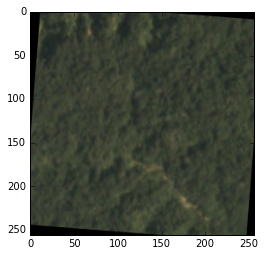

(256L, 256L, 3L)
[0 0 0 1]
()


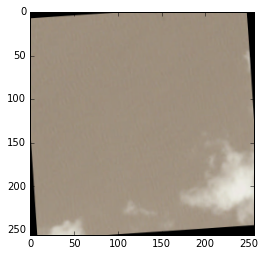

(256L, 256L, 3L)
[1 0 0 0]
()


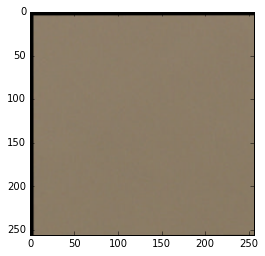

(256L, 256L, 3L)
[0 0 1 0]
()


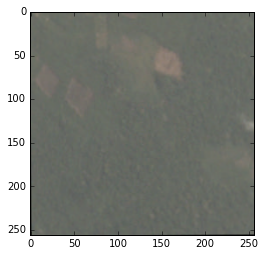

(256L, 256L, 3L)
[0 1 0 0]
()


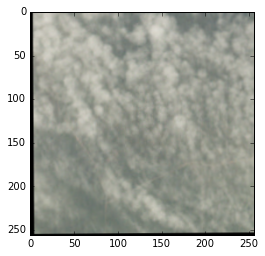

(256L, 256L, 3L)
[0 1 0 0]
()


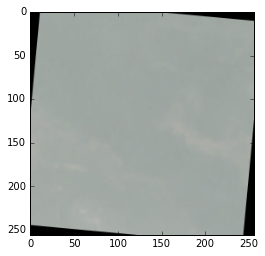

(256L, 256L, 3L)
[0 0 0 1]
()


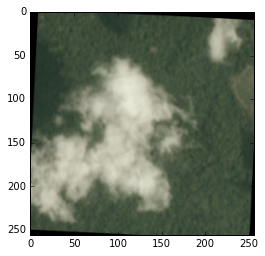

(256L, 256L, 3L)
[0 0 1 0]
()


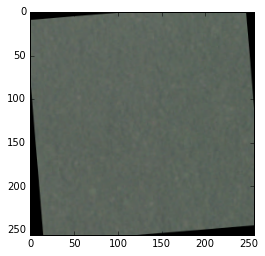

In [4]:
batch = train_gen.next()
print(batch[0].shape)

for i in range(batch[0].shape[0]):
    img = batch[0][i,:,:,:]
    #img = np.transpose(img, (1,2,0))
    print(img.shape)
    print(batch[1][i])
    print()
    plt.figure()
    plt.imshow(img)
    plt.show()

In [5]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

for layer in model.layers:
    layer.trainable = False
    
layer = Flatten()(model.output)
layer = BatchNormalization()(layer)
layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization()(layer)

output_layer = Dense(len(weather_labels), activation='softmax')(layer)

model = Model(inputs=model.input, outputs=output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [6]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=[3, 128, 128], activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(len(weather_labels), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(),
#              metrics=['accuracy', 'categorical_crossentropy'])

# model.summary()

In [7]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=[3, 256, 256]))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(len(weather_labels), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(),
#              metrics=['accuracy', 'categorical_crossentropy'])

# model.summary()

In [8]:
# model = Sequential()

# model.add(Conv2D(16, (3, 3), activation='relu', input_shape=[3, 256, 256]))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(len(weather_labels), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(),
#              metrics=['accuracy', 'categorical_crossentropy'])

# model.summary()

In [9]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint(filepath='E:/KI/Master/MLIP/Brainforest/WeatherTest/VGG/model.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose=1, save_best_only=True)

model.fit_generator(train_gen, steps_per_epoch=len(train_data)/batch_size,
                    epochs=25, verbose=1,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, validation_steps=len(val_data)/batch_size)

Epoch 1/25
3541/3541 [==============================] - 1886s - loss: 1.2431 - acc: 0.4769 - val_loss: 1.5957 - val_acc: 0.2936
Epoch 2/25
3541/3541 [==============================] - 1878s - loss: 1.1155 - acc: 0.5224 - val_loss: 1.7259 - val_acc: 0.3734
Epoch 3/25
3540/3541 [============================>.] - ETA: 0s - loss: 1.0608 - acc: 0.5546
Epoch 00002: reducing learning rate to 0.000500000023749.
Epoch 00002: val_loss did not improve
3541/3541 [==============================] - 1878s - loss: 1.0606 - acc: 0.5547 - val_loss: 1.9689 - val_acc: 0.3955
Epoch 4/25
3540/3541 [============================>.] - ETA: 0s - loss: 0.9615 - acc: 0.6121
Epoch 00003: reducing learning rate to 0.000250000011874.
Epoch 00003: val_loss did not improve
3541/3541 [==============================] - 1876s - loss: 0.9614 - acc: 0.6122 - val_loss: 2.0710 - val_acc: 0.3590
Epoch 5/25
3540/3541 [============================>.] - ETA: 0s - loss: 0.8566 - acc: 0.6648
Epoch 00004: reducing learning rate to 

KeyboardInterrupt: 

In [ ]:
# model.load_weights('E:/KI/Master/MLIP/Brainforest/WeatherTest/x/model.0x-0.xx.hdf5')

# val_gen_predict = get_data(val_data, jpg_path, val_labels, augmentation=False,
#                    batch_size=batch_size, img_size=(256, 256), shuffle=False)

# val_steps = int(np.ceil(float(len(val_data)) / float(batch_size)))
# preds = model.predict_generator(val_gen, val_steps)
# preds = preds[:len(val_data)]

# y_true_clear = val_labels[:,0]
# y_true_cloudy = val_labels[:,1]
# y_true_haze = val_labels[:,2]
# y_true_partly_cloudy = val_labels[:,3]

# y_pred_clear = preds[:,0] > 0.5
# y_pred_cloudy = preds[:,1] > 0.5
# y_pred_haze = preds[:,2] > 0.5
# y_pred_partly_cloudy = preds[:,3] > 0.5

# print 'f2 score clear:', fbeta_score(y_true_clear, y_pred_clear, 2)
# print 'f2 score cloudy:', fbeta_score(y_true_cloudy, y_pred_cloudy, 2)
# print 'f2 score haze:', fbeta_score(y_true_haze, y_pred_haze, 2)
# print 'f2 score partly cloudy:', fbeta_score(y_true_partly_cloudy, y_pred_partly_cloudy, 2)

In [ ]:
# model.load_weights("../../WeatherTest/model.00-9.72.hdf5")
# imgs, labels = next(val_gen)
# prediction = model.predict(imgs)
# for i in range(len(labels)):
#     print(labels[i], prediction[i])